# [Getting Started with Cloud-Native HLS Data in Python](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/)

This tutorial demonstrates how to work with the HLS Landsat 8 ([HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)) and Sentinel-2 ([HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)) data products.

The  Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat-8 and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial. 

## Methodology

This tutorial will show how to use the CMR-STAC API to investigate the HLS collections available in the cloud and search for and subset to the specific time period, bands (layers), and region of interest for our use case, load subsets of the desired COGs into a Jupyter Notebook directly from the cloud, stack the time series, visualize the time series.  

### Data Used in the Example  

- **Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)**
    - _The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - **Science Dataset (SDS) layers:** 
        - B12 (SWIR 2) 
        - B8A (NIR Narrow)  
        - B04 (Red)   


- **Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)**
    - _The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products._  
     - **Science Dataset (SDS) layers:**  
        - B07 (SWIR 2)  
        - B05 (NIR) 
        - B04 (Red)  
        
## Topics Covered  

1. [**Setup**](#setup)  
    1.1 Library import        
2. [**Navigating the CMR-STAC API**](#navigatestac)      
    2.1 Introduction to the CMR-STAC API 
    - 2.1.1 **STAC API**: Endpoint that enables the querying of STAC items
    - 2.1.2 **STAC Catalog**: Contains a JSON file of links that organize all of the collections available
    - 2.1.3. **STAC Collection**: Extension of STAC Catalog containing additional information that describe the STAC Items in that Collection
    - 2.1.4 **STAC Item**: Represents data and metadata assets that are spatiotemporally coincident
3. [**CMR-STAC API: Searching for Items**](#searchstac)      
    3.1 Spatial Querying via Bounding Box  
    3.2 Temporal Querying  
4. [**Extracting HLS COGs from the Cloud**](#extracthls)        
    4.1 Subset by Band   
    4.2 Load a Spatially Subset HLS COG into Memory  
5. [**Processing HLS Data**](#processhls)    
    5.1 Apply Scale Factor and Calculate EVI    
    5.2 Quality Filtering   
    5.3 Export to COG   
6. [**Automation**](#automation)     
7. [**Stacking HLS Data**](#stackhls)    
    7.1 Open COGs and Stack Using Xarray      
    7.2 Visualize Stacked Time Series  
    7.3 Export Statistics           


## Before Starting this Tutorial  

A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.

You will also need to have a netrc file set up in your home directory in order to successfully run the code below. Check out the `Setting up a netrc File` section in the [README](https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/README.md).

## 1. Setup <a id="setup"></a>

### 1.1 Library import

In [1]:
import os
import requests 
from sys import platform

import numpy as np
from osgeo import gdal
import rasterio as rio
from rasterio.mask import mask
import geopandas as gpd
from skimage import io
import geoviews as gv
from netrc import netrc
import pyproj
from shapely.ops import transform
import matplotlib.pyplot as plt

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
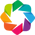

In [2]:
gv.extension('bokeh', 'matplotlib')

## 2. Navigating the CMR-STAC API <a id="navigatestac"></a>

In this section, we will learn about navigating NASA's Common Metadata Repository (CMR) SpatioTemporal Asset Catalog ([STAC](https://stacspec.org/)) API.  

### 2.1 Introduction to the CMR-STAC API 
#### 2.1.1 **STAC API**: Endpoint that enables the querying of STAC items. 

Set the CMR-STAC API Endpoint to a variable, and use the `requests` package to send a GET request to the endpoint, and set the response to a variable.

In [3]:
# CMR-STAC API Endpoint
STAC = 'https://cmr.earthdata.nasa.gov/stac/'  
#STAC = 'https://cmr.earthdata.nasa.gov/cloudstac'
# Call the STAC API endpoint
stac_response = requests.get(STAC).json()         
for s in stac_response: print(s)

id
title
stac_version
type
description
links


#### 2.1.2 **STAC Catalog**: Contains a JSON file of links that organize all of the collections available. 

Search for LP DAAC Catalogs, and print the information contained in the Catalog that we will be using today, `LPCLOUD`.

In [4]:
# Search for only LP-specific catalogs
stac_lp = [s for s in stac_response['links'] if 'LP' in s['title']]  

# LPCLOUD is the STAC catalog we will be using and exploring today
lp_cloud = requests.get([s for s in stac_lp if s['title'] == 'LPCLOUD'][0]['href']).json()
for l in lp_cloud: print(f"{l}: {lp_cloud[l]}")

id: LPCLOUD
title: LPCLOUD
description: Root catalog for LPCLOUD
type: Catalog
stac_version: 1.0.0
links: [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'title': 'Provider catalog', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'Root catalog', 'type': 'application/json'}, {'rel': 'collections', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'Provider Collections', 'type': 'application/json'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'GET'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'POST'}, {'rel': 'conformance', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance', 'title': 'Conformance Classes', 'type': 'application/geo+json'}, {'rel': 'ser

Print the links contained in the LPCLOUD STAC Catalog:

In [5]:
lp_links = lp_cloud['links']
for l in lp_links: 
    try: 
        print(f"{l['href']} is the {l['title']}")
    except:
        print(f"{l['href']}")  

https://cmr.earthdata.nasa.gov/stac/LPCLOUD is the Provider catalog
https://cmr.earthdata.nasa.gov/stac/ is the Root catalog
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections is the Provider Collections
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search is the Provider Item Search
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search is the Provider Item Search
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance is the Conformance Classes
https://api.stacspec.org/v1.0.0-beta.1/openapi.yaml is the OpenAPI Doc
https://api.stacspec.org/v1.0.0-beta.1/index.html is the HTML documentation
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/ASTGTM_NUMNC.v003
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/ASTGTM_NC.v003
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/ASTGTM.v003
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/WaterBalance_Daily_Historical_GRIDMET.v1.5
https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/ECO_L2G_CLOUD.v002
https://cmr.eart

#### 2.1.3 **STAC Collection**: Extension of STAC Catalog containing additional information that describe the STAC Items in that Collection.

Get a response from the LPCLOUD Collection and print the information included in the response.

In [6]:
# Set collections endpoint to variable
lp_collections = [l['href'] for l in lp_links if l['rel'] == 'collections'][0]  
# Call collections endpoint
pages = 1
for page in range(pages):
    response = requests.get(f"{lp_collections}?page={str(page + 1)}&limit=20").json()
    if page == 0:
        collections_response = response
    else:
        collections_response['collections'] = collections_response['collections'] + response['collections']

print(f"This collection contains {collections_response['description']} ({len(collections_response['collections'])} available)")

This collection contains All collections provided by LPCLOUD (20 available)


Print all STAC Collections provided by LPCLOUD

In [7]:
collections = collections_response['collections']
for n in range(len(collections)):
    print(collections[n]['title'])

ASTER Global Digital Elevation Model Attributes NetCDF V003
ASTER Global Digital Elevation Model NetCDF V003
ASTER Global Digital Elevation Model V003
Daily Historical Water Balance Products for the CONUS
ECOSTRESS Gridded Cloud Mask Instantaneous L2 Global 70 m V002
ECOSTRESS Gridded Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
ECOSTRESS Gridded Top of Atmosphere Calibrated Radiance Instantaneous L1C Global 70 m V002
ECOSTRESS Swath Attitude and Ephemeris Instantaneous L1B Global V002
ECOSTRESS Swath Cloud Mask Instantaneous L2 Global 70 m V002
ECOSTRESS Swath Geolocation Instantaneous L1B Global 70 m V002
ECOSTRESS Swath Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
ECOSTRESS Swath Top of Atmosphere Calibrated Radiance Instantaneous L1B Global 70 m V002
ECOSTRESS Tiled Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002
ECOSTRESS Tiled Top of Atmosphere Calibrated Radiance Instantaneous L1C Global 70 m V00

The `id` STAC field is used to query by a specific product. Be sure to save this ID for the HLS S30 and L30 v2.0 products below:

In [8]:
# Search available version 2 collections for HLS and print them out
hls_collections = [c for c in collections if 'HLS' in c['id'] and 'v2' in c['id']]
for h in hls_collections: 
    print(f"{h['title']} has an ID (shortname) of: {h['id']}")

HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0 has an ID (shortname) of: HLSL30.v2.0
HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0 has an ID (shortname) of: HLSS30.v2.0


In [9]:
for n in range(len(hls_collections)):
    print(hls_collections[n]['id'])

HLSL30.v2.0
HLSS30.v2.0


Explore the attributes of the HLSS30 collection.

In [10]:
ID = 'HLSS30.v2.0'

s30 = [h for h in hls_collections if h['id'] == ID][0]     # Grab HLSs30 collection

for l in s30['extent']:                                                                # Check out the extent of this collection
    print(f"{l}: {s30['extent'][l]}")   

spatial: {'bbox': [[-180, -90, 180, 90]]}
temporal: {'interval': [['2015-11-28T00:00:00.000Z', None]]}


Print the start date for HLSS30

In [11]:
print(f"HLS S30 Start Date is: {s30['extent']['temporal']['interval'][0][0]}")

HLS S30 Start Date is: 2015-11-28T00:00:00.000Z


#### 2.1.4 **STAC Item**: Represents data and metadata assets that are spatiotemporally coincident

Query the HLSS30 collection for items and return the first item in the collection. 

In [12]:
# Go through all links in the collection and return the link containing the items endpoint
s30_items = [s['href'] for s in s30['links'] if s['rel'] == 'items'][0]    # Set items endpoint to variable
s30_items

'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items'

In [13]:
s30_items_response = requests.get(f"{s30_items}").json()    # Call items endpoint
s30_item = s30_items_response['features'][-1]         # select first item (10 items returned by default)
s30_item

{'type': 'Feature',
 'id': 'HLS.S30.T55HCV.2015332T001732.v2.0',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'collection': 'HLSS30.v2.0',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[145.9180051, -37.1292639],
    [145.9878045, -36.8832566],
    [145.9974356, -36.1401611],
    [144.7776188, -36.1237355],
    [144.7490329, -37.1128273],
    [145.9180051, -37.1292639]]]},
 'bbox': [144.749033, -37.129264, 145.997436, -36.123736],
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items/HLS.S30.T55HCV.2015332T001732.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'},
  {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/L

STAC metadata provides valuable information on the item, including a unique ID, when it was acquired, the location of the observation, and a cloud cover assessment.  

In [14]:
# Print metadata attributes from this observation
print(f"The ID for this item is: {s30_item['id']}")
print(f"It was acquired on: {s30_item['properties']['datetime']}")
print(f"over: {s30_item['bbox']} (Lower Left, Upper Right corner coordinates)")
print(f"It contains {len(s30_item['assets'])} assets")
print(f"and is {s30_item['properties']['eo:cloud_cover']}% cloudy.")

The ID for this item is: HLS.S30.T55HCV.2015332T001732.v2.0
It was acquired on: 2015-11-28T00:17:27.450Z
over: [144.749033, -37.129264, 145.997436, -36.123736] (Lower Left, Upper Right corner coordinates)
It contains 20 assets
and is 0% cloudy.


Print out the names of all of the assets included in this item.

In [15]:
print("The following assets are available for download:")
for a in s30_item['assets']: print(a)

The following assets are available for download:
B03
SAA
B10
B11
B05
B07
Fmask
B8A
VZA
B08
B09
B12
VAA
SZA
B02
B01
B04
B06
browse
metadata


Each HLS item includes a browse image. Read the browse file into memory and visualize the HLS acquisition.

In [16]:
s30_item['assets']['browse']

{'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T55HCV.2015332T001732.v2.0/HLS.S30.T55HCV.2015332T001732.v2.0.jpg',
 'type': 'image/jpeg',
 'title': 'Download HLS.S30.T55HCV.2015332T001732.v2.0.jpg'}

Use the `skimage` package to load the browse image into memory and `matplotlib` to quickly visualize it.

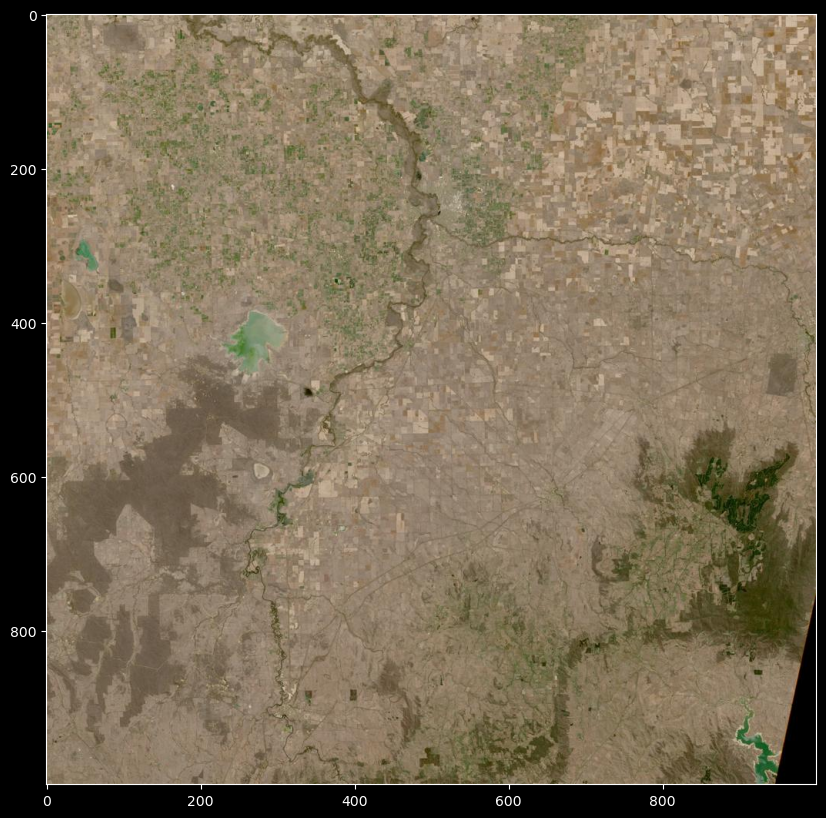

In [17]:
%matplotlib inline

# Load jpg browse image into memory
image = io.imread(s30_item['assets']['browse']['href'])    

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

## 3. CMR-STAC API: Searching for Items <a id="searchstac"></a>

In this section, instead of simply navigating through the structure of a STAC Catalog, use the search endpoint to query the API by region of interest and time period of interest.

### 3.1 Spatial Querying via Bounding Box 

The search endpoint is one of the links found in the  `LPCLOUD` STAC Catalog, which can be leveraged to retrieve STAC Items that match the submitted query parameters.

**Region of Interest**

Next, load in the spatial region of interest for our use case using `geopandas`. You will need to create the `map.geojson` from [http://geojson.io/](http://geojson.io/), and it must be stored in the `data/raw` directory. 

In [6]:
# Read region of interest
roi = gpd.read_file('../data/raw/map.geojson')
roi

geometry
0  POLYGON ((-16.58618 28.48557, -16.58618 28.246...

Combine a plot of the farm field boundary (combine two `geoviews` plots using `*`) with a basemap layer.

In [7]:
# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=500, height=500)
roi_geometry = roi['geometry'][0]
roi_shape = gv.Polygons(roi_geometry).opts(line_color='yellow', color=None)

base * roi_shape

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

**Search Endpoint**

Grab the search endpoint for the `LPCLOUD` STAC Catalog and send a POST request to retrieve items.

If we just call the search endpoint directly, it will default to returning the first 10 granules. Below, set a limit to return the first 100 matching items. Additional information on the spec for adding parameters to a search query can be found at: https://github.com/radiantearth/stac-api-spec/tree/master/item-search#query-parameters-and-fields. 

In [8]:
# Define the search endpoint
lp_search = [l['href'] for l in lp_links if l['rel'] == 'search'][0]    

# Set up a dictionary that will be used to POST requests to the search endpoint
params = {}

# Add in a limit parameter to retrieve 100 items at a time.
lim = 100
params['limit'] = lim  

Add the bounding box of the region of interest to the CMR-STAC API Search query using the `bbox` parameter.

In [9]:
bbox = list(roi_geometry.bounds)    # Defined from ROI bounds
params['bbox'] = bbox                                                                                 # Add ROI to params
params

{'limit': 100,
 'bbox': [-16.586176552409427,
  28.246946784524425,
  -16.299397197403778,
  28.48557209531775]}

### 3.2 Temporal Querying 

Finally, you can narrow your search to a specific time period of interest using the `datetime` parameter. Here we have set the time period of interest from August  15 2023 to September 2023. Additional information on setting temporal searches can be found in the [NASA CMR Documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#temporal-range-searches). 

In [10]:
date_time = "2023-08-10T00:00:00Z/2023-08-31T23:59:59Z"    # Define start time period / end time period
params['datetime'] = date_time
params

{'limit': 100,
 'bbox': [-16.586176552409427,
  28.246946784524425,
  -16.299397197403778,
  28.48557209531775],
 'datetime': '2023-08-10T00:00:00Z/2023-08-31T23:59:59Z'}

Next, add the `shortname` for the HLSS30 v2.0 product (HLSS30.v2.0) to the params dictionary, and query the CMR-STAC LPCLOUD search endpoint for just HLSS30 items.

In [11]:
s30_id = "HLSS30.v2.0"
params["collections"] = [s30_id]

In [12]:
# Search for the HLSS30 items of interest:
s30_items = requests.post(lp_search, json=params).json()['features']  # Send POST request with collection included
len(s30_items)

2

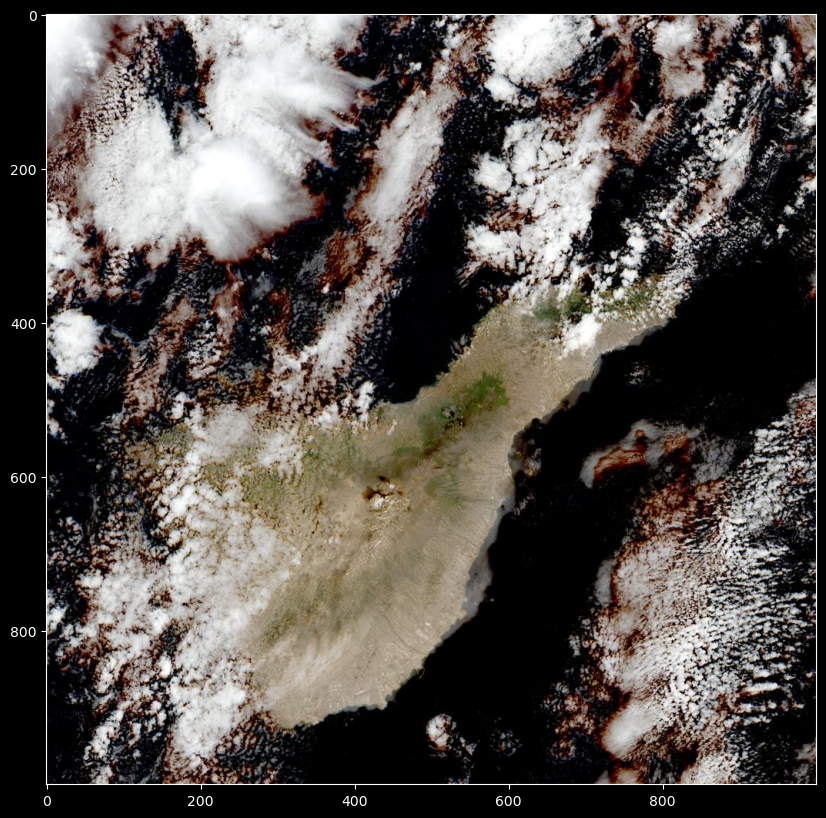

In [13]:
%matplotlib inline

# Load jpg browse image into memory
image = io.imread(s30_items[1]['assets']['browse']['href'])    

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Append the HLSL30 V2.0 Product shortname (ID) to the list under the `collections` parameter.

In [14]:
l30_id = "HLSL30.v2.0"
params["collections"].append(l30_id)

In [15]:
# Search for the HLSS30 and HLSL30 items of interest:
hls_items= requests.post(lp_search, json=params).json()['features']    # Send POST request with S30 and L30 collections included
len(hls_items)

3

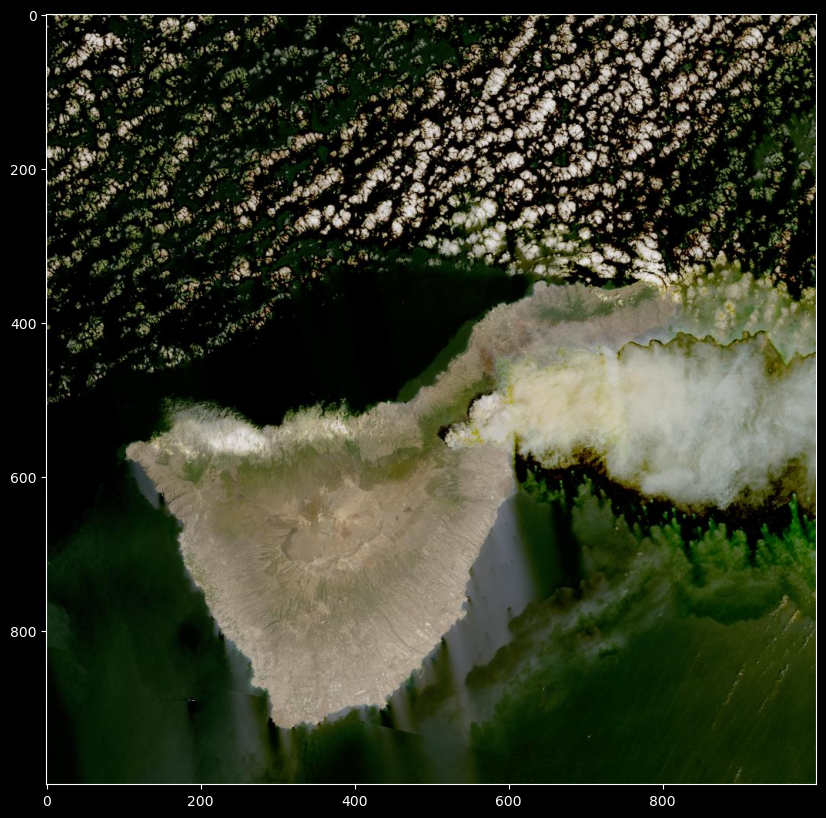

In [16]:
%matplotlib inline

# Load jpg browse image into memory
image = io.imread(hls_items[1]['assets']['browse']['href'])    

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

## 4. Extracting HLS COGs from the Cloud <a id="extracthls"></a>

In this section, configure `gdal` and `rasterio` to use `vsicurl` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

Accessing data stored in the Cloud is done using Python libraries that leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the HLS COG files.

In [17]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

Before accessing and loading the COGs into memory, run the cell below to configure the authentication to your [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) credentials, which will be needed to access the HLS files in the cells that follow. 

In [18]:
# Earthdata URL to call for authentication
urs = 'urs.earthdata.nasa.gov'   

# Determine if netrc file exists, and if it includes NASA Earthdata Login Credentials
if 'win' in platform:
    nrc = '../_netrc'
else:
    nrc = '../.netrc'
try:
    netrcDir = os.path.expanduser(f"{nrc}")
    netrc(netrcDir).authenticators(urs)[0]
    del netrcDir
except FileNotFoundError:
    print(f"{nrc} file not found.")

## 4.1 Subset by Band 

Subset by band by filtering to only include the SWIR, NIR, and Red layers in the list of links to access. 

The different band numbers for each of the two products:

**Sentinel 2**:
- SWIR 2= B12
- SWIR 1= B11
- NIR ("narrow") = B8A
- Red = B04 
- Green = B03 
- Blue = B02
    
**Landsat 8**:
- SWIR 2 = B07
- SWIR 1 = B06
- NIR = B05
- Red = B04
- Green = B03 
- Blue = B02

In [19]:
item = hls_items[2]

In [20]:
band_links = {}

# Define which HLS product is being accessed
if item['collection'] == 'HLSS30.v2.0':
    bands = ['B12', 'B11', 'B8A', 'B04', 'B03', 'B02'] # SWIR 2, SWIR 1, NIR, RED, GREEN, BLUE for S30
else:
    bands = ['B07', 'B06', 'B05', 'B04' 'B03', 'B02'] # SWIR 2, SWIR 1, NIR, RED, GREEN, BLUE for L30

# Band names
band_names = dict(zip(bands, ["swir_2", "swir_1", "nir", "red", "green", "blue"]))


# Subset the assets in the item down to only the desired bands
for a in item['assets']: 
    if any(b == a for b in bands):
        band_links[a] = item['assets'][a]['href']
        print(band_links[a])

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B8A.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B12.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B03.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28RCS.2023235T115219.v2.0/HLS.S30.T28RCS.2023235T115219.v2.0.B11.tif


Read the file using `rasterio`. 

In [21]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
band_metadata = {}
for band_name, band_link in band_links.items():
    band_metadata[band_name] = rio.open(band_link)

Take the ROI `shapely` polygon and convert it from lat/lon (EPSG: 4326) into the [native projection of HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). This must be done in order to use the ROI to subset the COG that is being pulled into memory--it must be in the native projection of the data being extracted. 

In [22]:
geo_CRS = pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)  # Source coordinate system of the ROI
utm = pyproj.Proj(band_metadata[bands[0]].crs)                                                  # Destination coordinate system
project = pyproj.Transformer.from_proj(geo_CRS, utm)                        # Set up the transformation
roi_geometry_utm = transform(project.transform, roi_geometry)    

Now, we can use the ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [23]:
# Extract the data for the ROI and clip to that bbox
band_data = {}
for band_name, data in band_metadata.items():
    band_data[band_name], _transform = rio.mask.mask(data, [roi_geometry_utm], crop=True)

Apply the scale factor to each array, and set the no-data values to `nan`.

In [24]:
# Grab scale factor from metadata and apply to each band
for band_name, data in band_data.items():
    band_data[band_name] = band_data[band_name][0] * band_metadata[band_name].scales[0]

# Set all nodata values to nan
for band_name, data in band_data.items():
    band_data[band_name][band_data[band_name] == band_metadata[band_name].nodata] = np.nan

Create a RGB image and display it

In [25]:
band_data = {band_names[key]: value for key, value in band_data.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


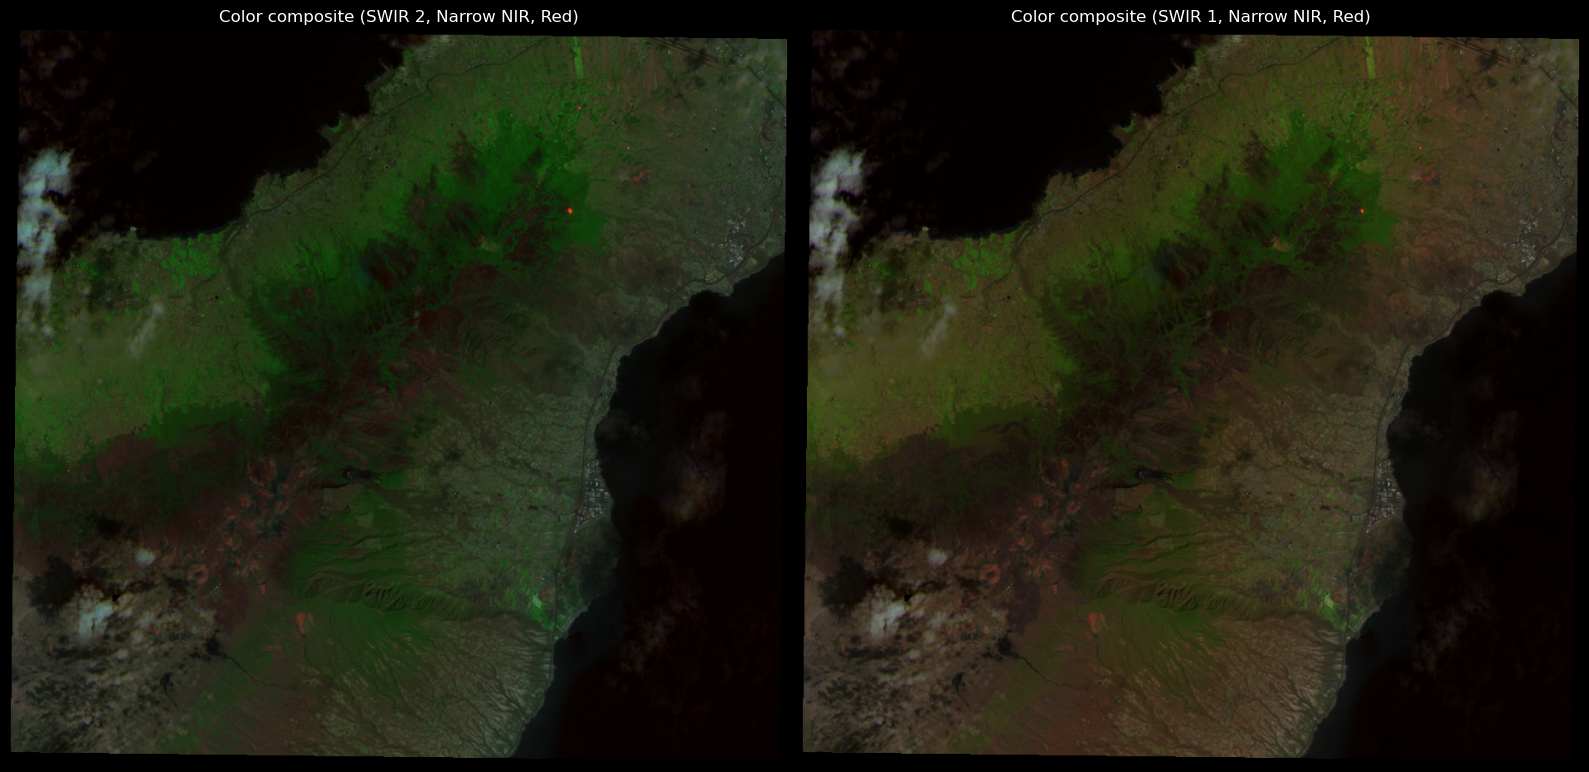

In [26]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Display the RGB image using the first axes
rgb_image = np.stack((band_data['swir_2'], band_data['nir'], band_data['red']), axis=-1)

ax[0].imshow(rgb_image)
ax[0].set_title("Color composite (SWIR 2, Narrow NIR, Red)")
ax[0].axis('off')

# Display another image using the second axes
rgb_image = np.stack((band_data['swir_1'], band_data['nir'], band_data['red']), axis=-1)

ax[1].imshow(rgb_image)
ax[1].set_title("Color composite (SWIR 1, Narrow NIR, Red)")
ax[1].axis('off')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()